In [20]:
options(warn=-1)

# import required library
if (!require(lubridate)) {
    install.packages('lubridate')
}
if (!require(lattice)) {
    install.packages('lattice')
}
if (!require(forecast)) {
    install.packages('forecast')
}

library(lubridate)
library(lattice)  # xyplot
library(forecast)

Loading required package: forecast
also installing the dependencies ‘quadprog’, ‘tseries’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘RcppArmadillo’



In [2]:
# load the data
train = read.csv('./train.csv')
test = read.csv('./test.csv')
# features = read.csv('./features.csv')
# stores = read.csv('./stores.csv')

# Processing and Visualization

In [3]:
## How many depts?
length(unique(train$Dept))
## How many stores?
length(unique(train$Store))

[1] 81

[1] 45

In [4]:
dept_store_train = table(train$Dept,train$Store)
dept_store_test = table(test$Dept, test$Store)
dim(dept_store_train)
dim(dept_store_test)

[1] 81 45

[1] 81 45

In [5]:
## 11 stores in the test do not have historical data
tmp = (dept_store_train ==0 )*(dept_store_test > 0)
sum(tmp)

[1] 11

In [6]:
## Names for the 81 departments
dept.names = sort(unique(train$Dept))

missing_dept_store = which(tmp>0, arr.ind=TRUE, useNames = FALSE)
missing_dept_store[, 1] = dept.names[missing_dept_store[,1]]
missing_dept_store = missing_dept_store[order(missing_dept_store[,1], missing_dept_store[,2]),]

# order the missing dept+store by stores and dept
missing_dept_store

29,37
30,36
30,42
39,34
39,45
43,18
43,24
99,5
99,9
99,10
99,25


In [7]:
# transform the date
train$Date = as.Date(train$Date, '%Y-%m-%d')
test$Date = as.Date(test$Date, '%Y-%m-%d')

train$Yr = year(train$Date)
test$Yr = year(test$Date)

train$Mon = month(train$Date)
test$Mon = month(test$Date)

In [8]:
head(train)

Store,Dept,Date,Weekly_Sales,IsHoliday,Yr,Mon
1,1,2010-02-05,24924.50,FALSE,2010,2
1,1,2010-02-12,46039.49,TRUE,2010,2
1,1,2010-02-19,41595.55,FALSE,2010,2
1,1,2010-02-26,19403.54,FALSE,2010,2
1,1,2010-03-05,21827.90,FALSE,2010,3
1,1,2010-03-12,21043.39,FALSE,2010,3


In [9]:
# get week information
train.wk = train$Date
train.wk = train.wk - train.wk[1]  # date is now 0, 7, 14, ...
train.wk = train.wk/7 + 5  # make 2010-2-5 as '5', and date becomes continuous integers
train.wk = as.numeric(train.wk) %% 52  ## 52 weeks in a year
train$Wk = train.wk

test.wk = test$Date
test.wk = test.wk - test.wk[1]
test.wk = test.wk/7 + 44 # make 2012-11-02 as '44'.
test.wk = as.numeric(test.wk) %% 52
test$Wk = test.wk

In [10]:
head(train)

Store,Dept,Date,Weekly_Sales,IsHoliday,Yr,Mon,Wk
1,1,2010-02-05,24924.50,FALSE,2010,2,5
1,1,2010-02-12,46039.49,TRUE,2010,2,6
1,1,2010-02-19,41595.55,FALSE,2010,2,7
1,1,2010-02-26,19403.54,FALSE,2010,2,8
1,1,2010-03-05,21827.90,FALSE,2010,3,9
1,1,2010-03-12,21043.39,FALSE,2010,3,10


In [11]:
table(train$Wk[train$IsHoliday])
table(test$Wk[test$IsHoliday])


   0    6   36   47 
5946 8895 8861 5959 


   0    6   47 
2988 2964 2976 

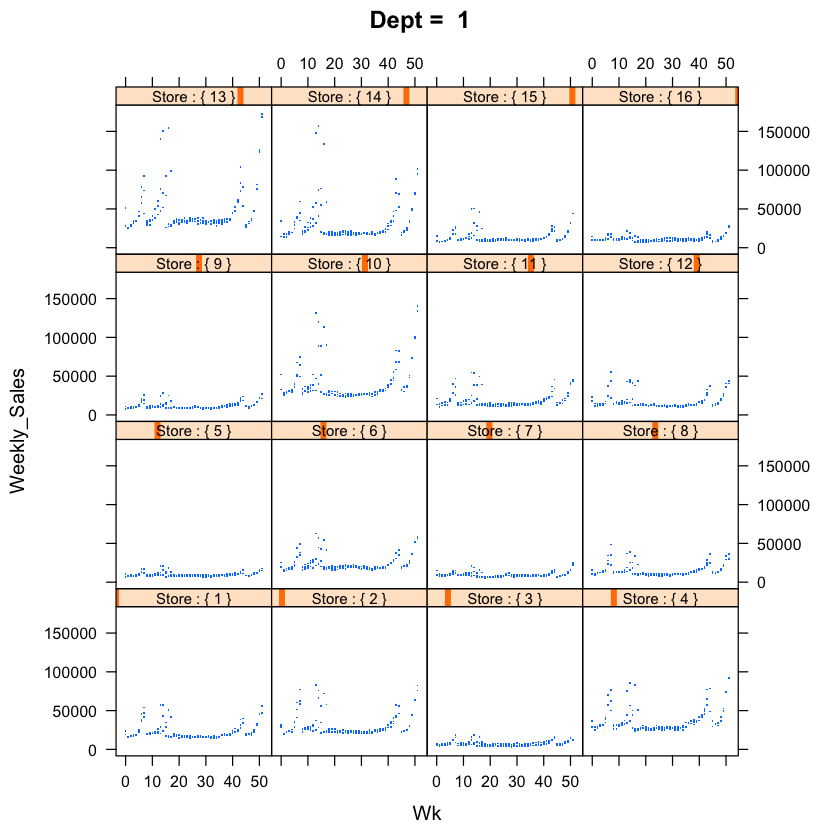

In [13]:
d = 1  # first department
tempData = subset(train, Dept == d)
tempData = subset(tempData, Store %in% c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16))
xyplot(Weekly_Sales ~ Wk | Store, tempData, main=paste("Dept = ", d),
       par.strip.text=list(cex=0.75), pch=".",
       strip = strip.custom(strip.names = TRUE, strip.levels = TRUE),
       layout = c(4, 4)
       )

In [14]:
table(train$Yr, train$Mon)

      
           1     2     3     4     5     6     7     8     9    10    11    12
  2010     0 11839 11788 14697 11672 11661 14561 11603 11724 14667 11712 14755
  2011 11695 11741 11813 14746 11820 11723 14621 11765 14761 11820 11901 15047
  2012 11850 11946 14850 11889 11822 14753 11798 14801 11854 11875     0     0

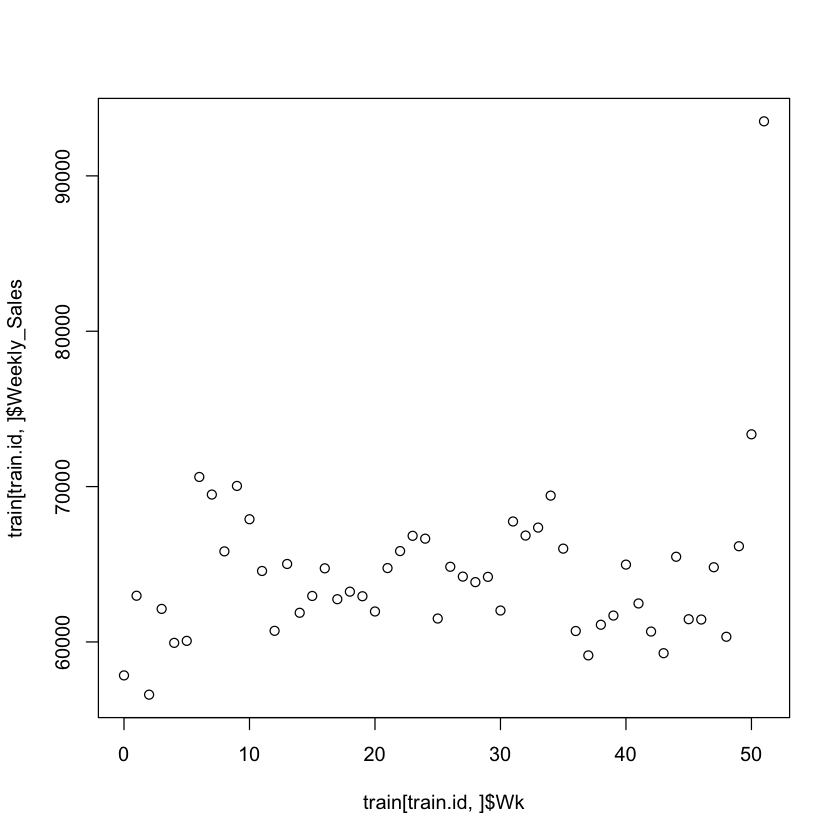

In [16]:
store = 2
dept = 2
wk = 10
train.id = which(train$Store == store & train$Dept == dept & train$Yr == 2011)
#options(repr.plot.width=5, repr.plot.height=5)
plot(train[train.id, ]$Weekly_Sales ~ train[train.id, ]$Wk)

# Winner's code

In [21]:
library(plyr)  # join
library(reshape)  # cast
library(forecast)  # stlf

# model
all.stores = unique(test$Store)
num.stores = length(all.stores)
train.dates = unique(train$Date)
num.train.dates = length(train.dates)
train.frame = data.frame(Date=rep(train.dates, num.stores),
                        Store=rep(all.stores, each=num.train.dates))

In [47]:
# Dimension reduction using SVD.
preprocess.svd = function(train, n.comp){
    train[is.na(train)] = 0
    z = svd(train[, 2:ncol(train)], nu=n.comp, nv=n.comp)
    s = diag(z$d[1:n.comp])
    train[, 2:ncol(train)] = z$u %*% s %*% t(z$v)
    train
}

In [48]:
n.comp = 12 # keep first 12 components

d = 1  # first department
tr.d = train.frame
tr.d = join(tr.d, train[train$Dept==d, c('Store','Date','Weekly_Sales')])  # perform a left join.
tr.d = cast(tr.d, Date ~ Store)  # row is Date, col is Store, entries are the sales

Joining by: Date, Store
Using Weekly_Sales as value column.  Use the value argument to cast to override this choice


In [49]:
# apply SVD for tr.d
tr.d = preprocess.svd(tr.d, n.comp)   

test.dates = unique(test$Date)
num.test.dates = length(test.dates)
forecast.frame = data.frame(Date=rep(test.dates, num.stores),
                       Store=rep(all.stores, each=num.test.dates))
fc.d = forecast.frame
fc.d$Weekly_Sales = 0
fc.d = cast(fc.d, Date ~ Store)  # similar as tr.d

Using Weekly_Sales as value column.  Use the value argument to cast to override this choice


In [63]:
length(tr.d[, 2])

[1] 143

In [53]:
s = ts(tr.d[, 2], frequency = 52)

In [56]:
horizon = nrow(fc.d)
fc = stlf(s, h=horizon, s.window=3, method='arima', ic='bic')

In [60]:
s

Time Series:
Start = c(1, 1) 
End = c(3, 39) 
Frequency = 52 
  [1] 25499.84 46525.01 38517.16 20141.72 21845.25 21150.68 21775.52 24323.96
  [9] 57830.43 43768.34 16971.97 16251.97 16857.80 18365.50 18739.34 16569.44
 [17] 16464.17 17603.81 17719.69 17131.80 16901.35 17086.21 17390.92 17084.86
 [25] 16069.59 16711.44 16942.60 16449.92 16132.19 16060.47 17883.85 18996.87
 [33] 19425.92 18823.78 20424.06 23223.73 25365.42 27391.33 37779.29 33476.45
 [41] 18686.53 19382.56 18438.92 23902.63 32677.82 46439.33 52869.29 19454.67
 [49] 15360.06 17306.56 17570.14 18350.44 21467.35 36899.29 46799.32 17249.20
 [57] 19101.32 19811.54 20112.24 19381.79 20125.15 22974.17 28028.78 53385.60
 [65] 41099.61 18189.06 16772.00 15183.82 15108.80 15823.24 15470.42 15590.97
 [73] 15354.73 15313.34 15189.70 15865.65 15047.35 15332.71 16072.85 15295.96
 [81] 15548.83 14961.64 16854.32 17977.97 19220.85 18707.37 19007.91 21965.59
 [89] 22709.38 24096.27 31647.53 38816.14 20160.21 19091.33 19711.79 23417.91
 [

In [ ]:
horizon = nrow(fc.d)  # number of steps ahead to forecast
for(j in 2:ncol(tr.d)){ # loop over stores
    s = ts(tr.d[, j], frequency = 52)  # convert sales to time series. 
    fc = stlf(s, h=horizon, s.window=3, method='arima', ic='bic')
    pred = as.numeric(fc$mean)
    fc.d[, j] = pred
}